In [3]:
import numpy as np
import pandas as pd
import matplotlib as mplt
import matplotlib.pyplot as plt
import functools

In [4]:
csvs = ["threads","fastflow","fastflow_blocking","fastflow_blocking_no_map","threads_pinned","omp"]
df = pd.concat([pd.read_csv(f"../data/{csv}.csv") for csv in csvs]).reset_index()

sequentials = pd.read_csv("../data/sequential.csv").reset_index()

In [5]:
programs = df['name'].unique()
all_n_workers = df['nworkers'].unique()
filenames = df['filename'].unique()

def crop_slash(e): return e.split('/')[1]

# Speedup

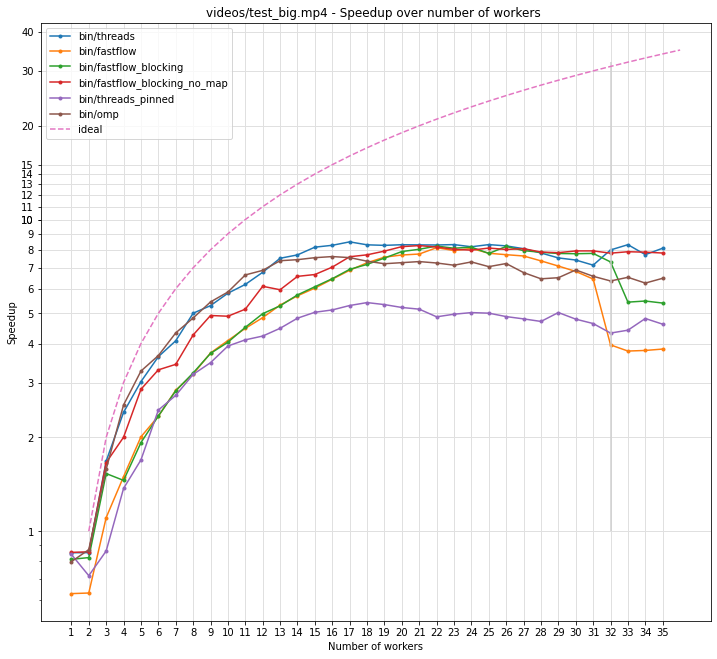

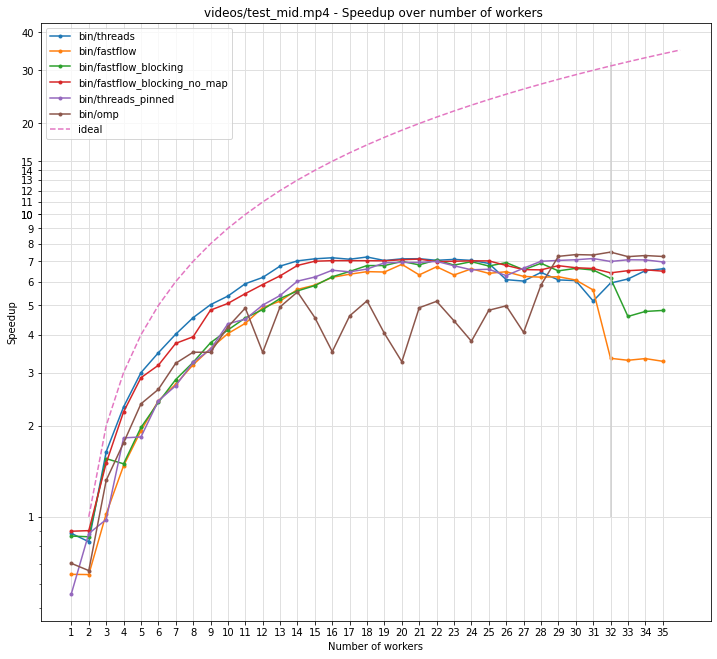

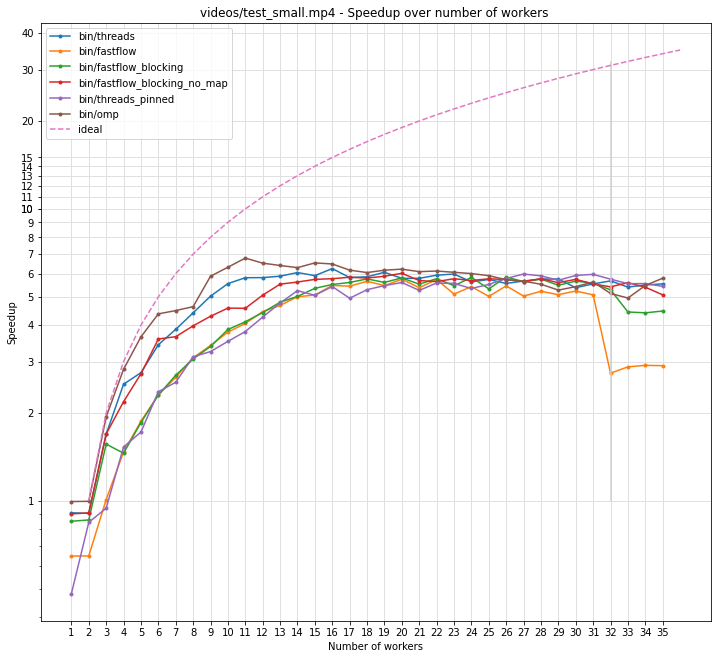

In [14]:
for f in filenames:
    plt.gcf().set_size_inches(12, 11) 
    seq_time = sequentials[sequentials['filename'] == f]['avg'].values[0]
    for p in programs:
        x = df[(df['name'] == p) & (df['filename'] == f)]['nworkers']
        y = seq_time / df[(df['name'] == p) & (df['filename'] == f)]['avg']
        plt.plot(x, y, label=p, marker='.')
    plt.grid(color='#e0e0e0', linestyle='-', linewidth=1)
    plt.yscale('log')
    plt.yticks(list(range(0,16,1)) + list(range(10,100,10)))
    plt.gca().get_yaxis().set_major_formatter(mplt.ticker.ScalarFormatter())
    plt.gca().get_yaxis().get_major_formatter().labelOnlyBase = False
    plt.vlines(32, ymin=1, ymax=32, color='#d0d0d0', linestyle='-')

    plt.plot(all_n_workers+1, all_n_workers, '--', label='ideal')
    plt.xticks(all_n_workers)

    plt.legend()
    plt.ylabel("Speedup")
    plt.xlabel("Number of workers")
    plt.title(f"{f} - Speedup over number of workers ")
    plt.savefig(f'speedup_{crop_slash(f)}.svg')  
    plt.show()

# Completion time

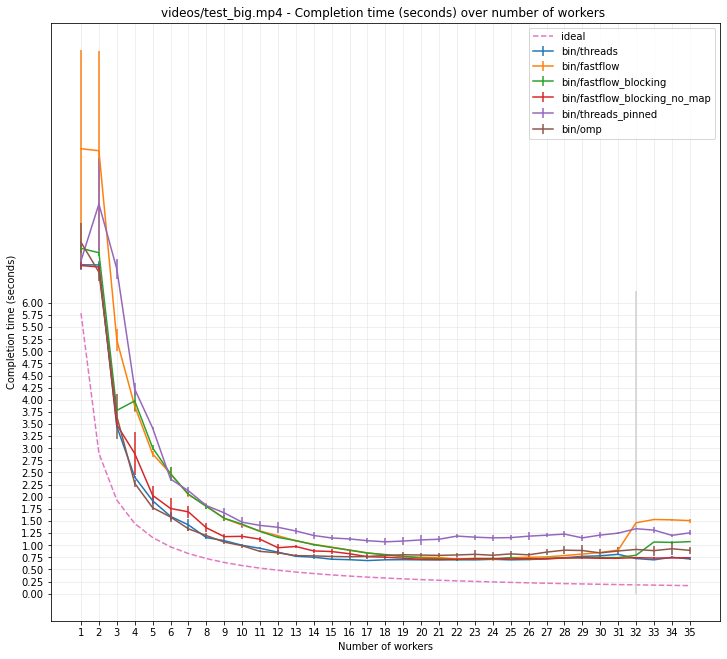

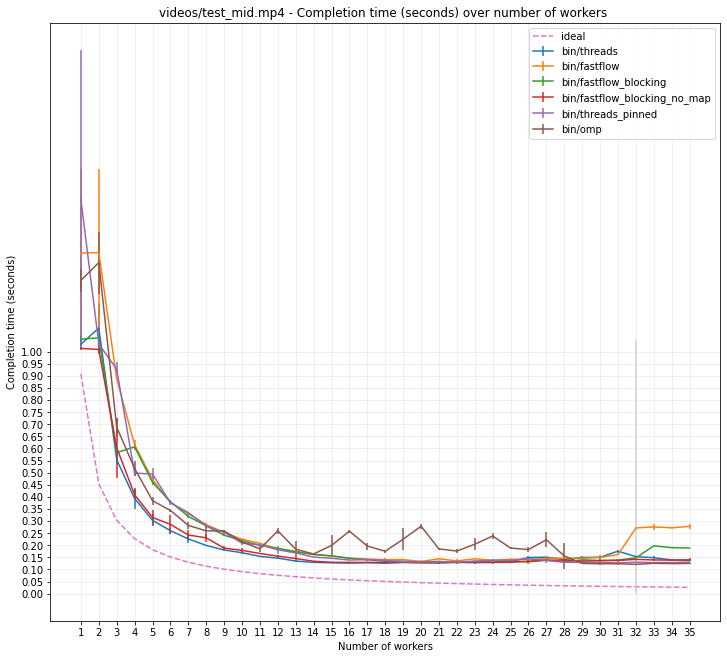

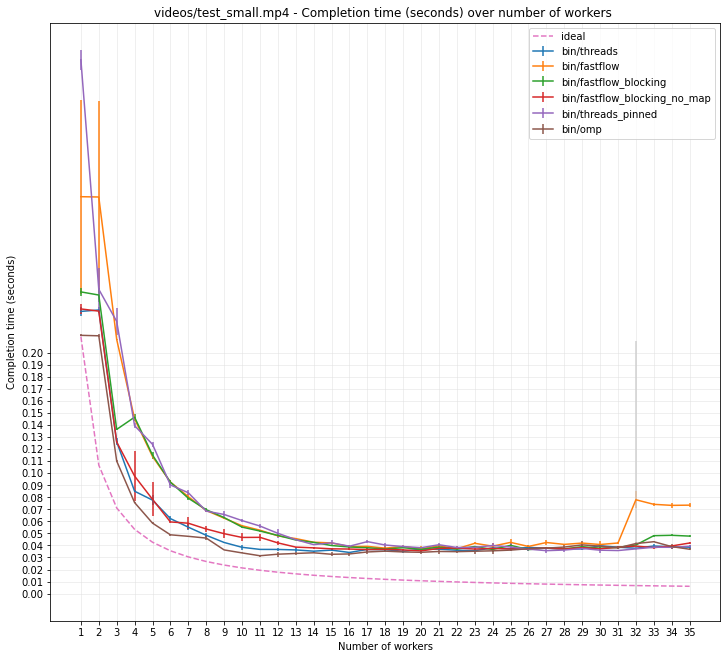

In [15]:
for f in filenames:
    plt.gcf().set_size_inches(12, 11) 
    seq_time = sequentials[sequentials['filename'] == f]['avg'].values[0]
    for p in programs:
        x = df[(df['name'] == p) & (df['filename'] == f)]['nworkers']
        y = df[(df['name'] == p) & (df['filename'] == f)]['avg']
        e = df[(df['name'] == p) & (df['filename'] == f)]['std']
        plt.errorbar(x, y/1e7, yerr=e/1e7, label=p)
    plt.grid(color='#e0e0e0', linestyle='-', linewidth=0.5)
    plt.plot(all_n_workers, seq_time/1e7/all_n_workers, '--', label='ideal')
    plt.xticks(all_n_workers)
    
    if f == 'videos/test_big.mp4':
        plt.yticks([x*0.25 for x in range(0,25,1)])
        plt.vlines(32, ymin=0, ymax=25*0.25, color='#d0d0d0', linestyle='-')
    if f == 'videos/test_mid.mp4':
        plt.yticks([x*0.05 for x in range(0,21,1)])
        plt.vlines(32, ymin=0, ymax=21*0.05, color='#d0d0d0', linestyle='-')
    if f == 'videos/test_small.mp4':
        plt.yticks([x*0.01 for x in range(0,21,1)])
        plt.vlines(32, ymin=0, ymax=21*0.01, color='#d0d0d0', linestyle='-')

    plt.legend()
    plt.ylabel("Completion time (seconds)")
    plt.xlabel("Number of workers")
    plt.title(f"{f} - Completion time (seconds) over number of workers ")
    plt.savefig(f'completion_time_{crop_slash(f)}.svg')  
    plt.show()

# Efficiency

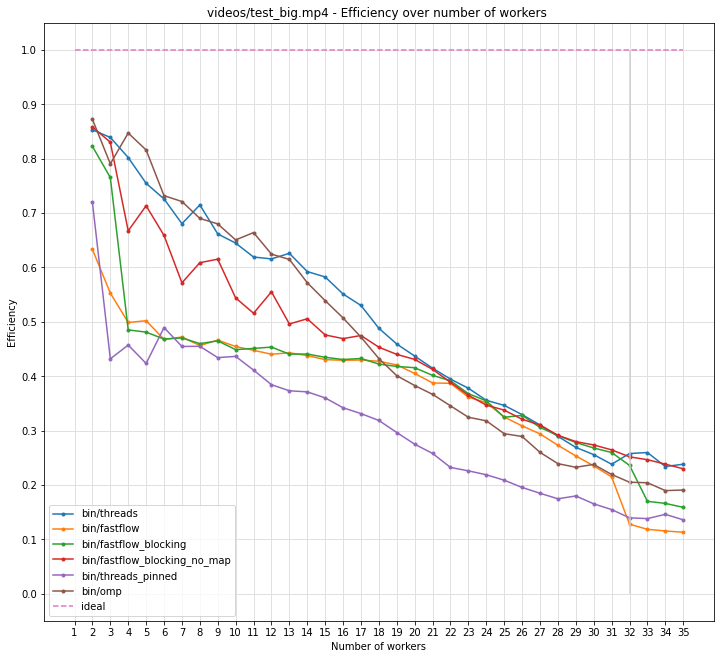

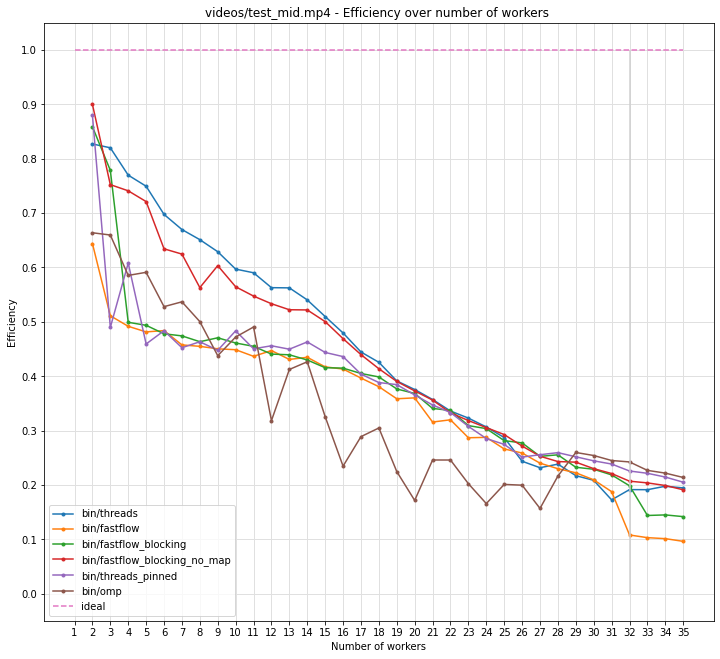

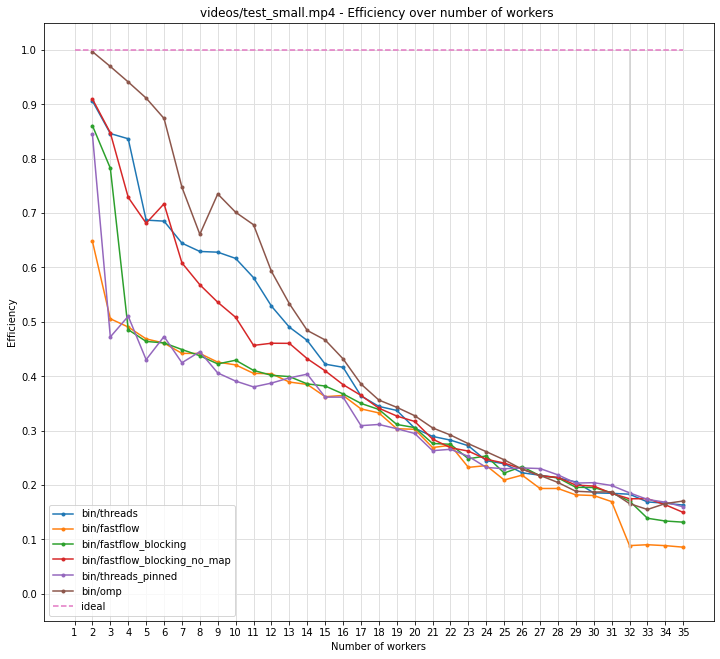

In [19]:
for f in filenames:
    plt.gcf().set_size_inches(12, 11) 
    seq_time = sequentials[sequentials['filename'] == f]['avg'].values[0]
    for p in programs:
        x = df[(df['name'] == p) & (df['filename'] == f)]['nworkers']
        y = (seq_time / (x - 1)) / df[(df['name'] == p) & (df['filename'] == f)]['avg']
        plt.plot(x, y, label=p, marker='.')
    plt.grid(color='#e0e0e0', linestyle='-', linewidth=1)
    plt.yticks([x*0.1 for x in range(0,11,1)])
    plt.gca().get_yaxis().set_major_formatter(mplt.ticker.ScalarFormatter())
    plt.gca().get_yaxis().get_major_formatter().labelOnlyBase = False
    plt.vlines(32, ymin=0, ymax=1, color='#d0d0d0', linestyle='-')

    plt.plot(all_n_workers, all_n_workers * 0 + 1, '--', label='ideal')
    plt.xticks(all_n_workers)

    plt.legend()
    plt.ylabel("Efficiency")
    plt.xlabel("Number of workers")
    plt.title(f"{f} - Efficiency over number of workers ")
    plt.savefig(f'efficiency_{crop_slash(f)}.svg')  
    plt.show()